**Instructors**: Prof. Keith Chugg (chugg@usc.edu)

**Notebook**: Written by Prof. Keith Chugg.

# Linear Least Squares (L2, MSE) Binary Classifier

In this notebook, we will consider a linear classifier for two classes.  

The discriminant function is
$$D({\bf x}) = {\bf w}^T \dot {\bf x} $$
This function is compared against 0 to make the class decision.  Specifically, if $D({\bf x}) > 0 $, then ${\bf x}$ is classified to class 0, otherwise it is classified as class 1.  

This means that the labeling convention is:
$$ \mathrm{Class~} 0: ~~\tilde{y} = +1 ~~~~~~ \mathrm{Class~}  1:~~ \tilde{y} = -1 $$

Specifically, in the least squares classifier, we convert the classification problem into a to a least squares regression problem.  We do so by setting the target for the $p^{th}$ data vector ${\bf x}_p$ to $y_p = +1$ if ${\bf x}_p$ is from class 0 and $y_p = -1$ if ${\bf x}_p$ is from class 1.  We will find a solution to this regression problem and then classify based on the sign of $\hat{y}({\bf x})$ -- i.e., decide class 0 if $\hat{y}({\bf x})> 0$ and decide class 1 otherwise.  


Specifically, we seek the parameters $$\{w_0, w_1, \ldots w_{N} \}$$ that minimize
$$g({\bf w}) = \frac{1}{P} \sum_{p=1}^{P} [y_p - {\bf w}^T \dot{\bf x}_p]^2 $$
where $\dot{\bf x}_p$ is the $p^{\th}$ data augmented data vector and ${\bf x}$ is the augmented weight vector.  
$$ {\bf w} =  \left[  \begin{array}{c} w_0 \\ w_1 \\ \vdots \\  w_N \end{array}\right], ~~~~~
\dot{\bf x} =  \left[  \begin{array}{c} 1 \\ x_1 \\ \vdots \\ x_N \end{array}\right]$$

With this cost function, we can stack the $P$ terms into a vector and obtain
$$g( {\bf w}) = \frac{1}{P}  \| {\bf y} - {\bf X} {\bf w} \|^2$$
where the $p^{th}$ row of ${\bf X}$ is $\dot{\bf x}^T$ and the $p^{th}$ row/element of ${\bf y} - {\bf X} {\bf w}$ is $[y_p - {\bf w}^T \dot{\bf x}_p]^2$.   

## Closed Form Solution
Minimizing $g( {\bf w})$ above is a linear algebra problem that you have likely seen before.  Specifically, assuming that ${\bf X}^T{\bf X}$ is invertible, the solution is given by
$${{\bf w}} = \left( {\bf X}^T{\bf X} \right)^{-1} {\bf X}^T {\bf y} $$
The dimensions of $\tilde{\bf X}^T\tilde{\bf X}$ are $(N+1 \times N+1)$, so the utility of this direct method (i.e., solving in closed form) is limited to small dimensional problems.  


## Trying the LS Binary Classifier Out

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

Below is a function that generates a synthetic data sets with directional preference and/or non-Gaussian distributions.  Understanding this is not needed for EE460, but if you have had EE364, you should be able to understand the code.

In [2]:
def generate_colored_nongaussian_data(means, lambdas, thetas, Ns, distribution='normal', quiet_mode='true'):
    """
    means: shape (2, 2), means[0] is the 2 x 1 mean vector for class 1 data generation
    lambdas: shape (2, 2), lambdas[0] are the 2 eigenvalues of the covariance matrix for generatinge data for class 1
    Ns: [N1, N2] the number of samples to be generated for each of teh two classes.
    distribution: in {normal, exponential, uniform} sets the distribution to generate data for both classes.
    quiet_mode: added this so that it won't print the details unless quiet_mode == False
    """
    N1 = Ns[0]
    N2 =  Ns[1]
    N = N1 + N2
    x = np.zeros((N, 2))
    assert distribution in {'normal', 'exponential', 'uniform'}, f'The {distribution} is not supported, only normal, exponential, uniform distributions are supported.'
    assert np.min(lambdas) > 0, f'lambda all have to be > 0 as they are variaces of the random vector projected onto the eigen-vectors.  You passed lambdas = {lambdas}'
    if distribution == 'normal':
        x[:N1] = np.random.normal(0, 1, (N1, 2))
        x[N1:] = np.random.normal(0, 1, (N2, 2))
    elif distribution == 'exponential':
        ## np.random.exponential(1) generates realizations from a unit variance, mean 1
        x[:N1] = np.random.exponential(1, (N1, 2)) - 1
        x[N1:] = np.random.exponential(1, (N2, 2)) - 1
    elif distribution == 'uniform':
        ## variance of uniform on (a,b) is (b-a)^2 / 12
        a = np.sqrt(3)
        x[:N1] = np.random.uniform(-a, a, (N1, 2))
        x[N1:] = np.random.uniform(-a, a, (N1, 2))

    def compute_coloring_matrix(theta, lams):
        E = np.asarray([ [np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)] ])
        Lambda_root = np.sqrt( np.asarray([ [lams[0], 0], [0, lams[1]] ]) )
        H = E @ Lambda_root
        K = H @ H.T
        return H, K

    H1, K1 = compute_coloring_matrix(thetas[0], lambdas[0])
    H2, K2 = compute_coloring_matrix(thetas[1], lambdas[1])

    x[:N1] = x[:N1] @ H1.T + means[0]
    x[N1:] = x[N1:] @ H2.T + means[1]

    labels = np.ones(N)
    labels[N1:] += 1

    sample_means = np.zeros((2,2))
    sample_means[0] = np.mean(x[:N1], axis=0)
    sample_means[1] = np.mean(x[N1:], axis=0)

    if not quiet_mode:
        print(f'Data generated under the {distribution} distribution')
        Ks = [K1, K2]
        Hs = [H1, H2]

        for i in range(2):
            print(f'The mean in the generating pdf for class {i + 1} is: {means[i]}')
            print(f'The sample mean for class {i + 1}  data is: {sample_means[i]}\n')

            print(f'The coloring matrix class {i + 1}  data is:\n {Hs[i]}')
            print(f'The covariance matrix class {i + 1}  data is:\n {Ks[i]}\n\n')

    return x, labels, sample_means

Let's generate some daat with a Gaussian distribution and with no directional preference.

In [8]:
means = np.asarray( [ [5, 0], [-5, 0] ])
lambdas = np.asarray( [ [4, 4], [4, 4] ])  
thetas = np.asarray([ 0, 0 ])
Ns = np.asarray([500, 500])

x, labels, sample_means = generate_colored_nongaussian_data(means, lambdas, thetas, Ns, distribution='normal')

Now let's construct ${\bf X}$ and find the LS classifier.  There are many ways in python to solve this linear least squares problem.  
most use matrix factorization methods that are more numerically stable than computing the inverse of (X^T X)
for this D=2 case, however, doing that would work just fine. Below, we use the [NumPy Least Squares solver](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html).

w_ls = [0.00828881 0.16897694 0.00623658]


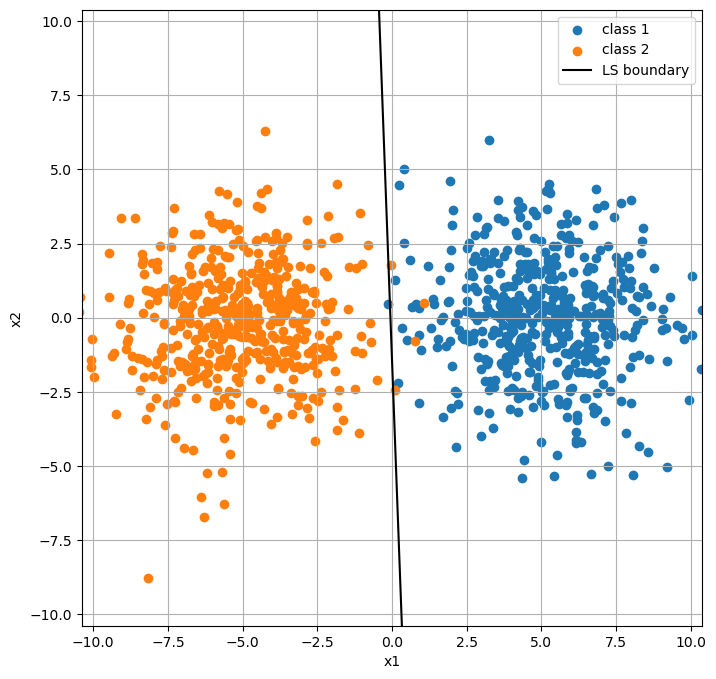

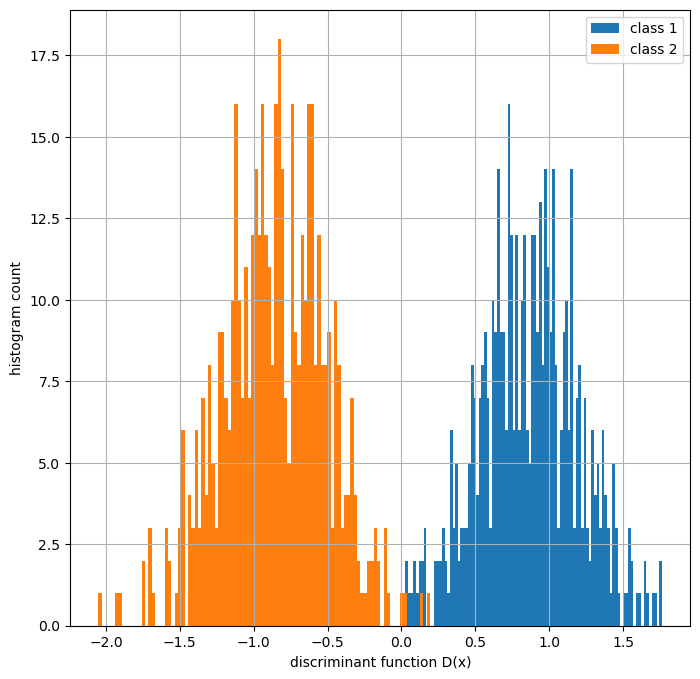

In [9]:
def solve_plot_ls_classifier(x, labels):
    P = x.shape[0]
    X_tilde = np.ones((P, 3))   ## the feature vector is dimension 2, and this is the extended version   
    X_tilde[:, 1:] = x          ## the first column is all 1s, this sets the rest of each row to the data samples
    y = (-1.0) ** (labels + 1)       ## (-1)^(1 + 1) = +1 and (-1)^(2+1) = -1, maps class 1 and class 2 to +1, -1, resp.
    ## solve the LS fit
    w_ls, Re, rank, singular_vals = np.linalg.lstsq(X_tilde, y, rcond=None)

    plt.figure(figsize=(8, 8))
    LIMIT = np.max(x)
    ## extract data separately for class 1 and class 2
    x_1 = x[labels==1]
    x_2 = x[labels==2]
    x_plot = np.arange(-1 * LIMIT, LIMIT, 0.01)
    plt.scatter(x_1.T[0], x_1.T[1], label='class 1')
    plt.scatter(x_2.T[0], x_2.T[1], label='class 2')
    ## plot the decision boundary which is g(x) = 0
    plt.plot( x_plot, -1 * ( w_ls[1] *  x_plot  + w_ls[0] ) / w_ls[2], c='k', label='LS boundary')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid(':')
    plt.xlim([-LIMIT, LIMIT])
    plt.ylim([-LIMIT, LIMIT])

    plt.figure(figsize=(8, 8))
    g1 = x_1 @ w_ls[1:] + w_ls[0]
    g2 = x_2 @ w_ls[1:] + w_ls[0]
    _ = plt.hist(g1, bins = 100, label='class 1')
    _ = plt.hist(g2, bins = 100, label='class 2')
    plt.legend()
    plt.grid(':')
    plt.xlabel('discriminant function D(x)')
    plt.ylabel('histogram count')
    
    print(f'w_ls = {w_ls}')
solve_plot_ls_classifier(x, labels)